## Machine Learning - Clusterização</font>

### Mini-Projeto - Agrupando Clientes Por Consumo de Energia</font>

A partir de dados de consumo de energia de clientes, nosso trabalho é agrupar os consumidores por similaridade a afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [2]:
# Carregando os dados
dataset = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)

In [3]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


### Análise Exploratória e pré-processamento dos dados

In [4]:
# Verificando o shape dos dados
dataset.shape

(2075259, 9)

In [5]:
# Verificando o tipo dos dados
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [6]:
# Verificando se há valores missing
dataset.isnull().sum().sort_values(ascending=False)

Sub_metering_3           25979
Sub_metering_2               0
Sub_metering_1               0
Global_intensity             0
Voltage                      0
Global_reactive_power        0
Global_active_power          0
Time                         0
Date                         0
dtype: int64

In [7]:
# Como as colunas, exceto a última, não são do tipo numérica, não está sendo possível verificar os valores missing.
# Para tratar os valores missing, primeiramente os dados serão convertidos para numérico.

colunas_transf = ["Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity", "Sub_metering_1", "Sub_metering_2"]

for coluna in colunas_transf:
    dataset[coluna] = pd.to_numeric(dataset[coluna], errors = "coerce")


In [8]:
# Verificando novamente o tipo dos dados
dataset.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [9]:
# Verificando se há valores missing
dataset.isnull().sum().sort_values(ascending=False)

Sub_metering_3           25979
Sub_metering_2           25979
Sub_metering_1           25979
Global_intensity         25979
Voltage                  25979
Global_reactive_power    25979
Global_active_power      25979
Time                         0
Date                         0
dtype: int64

Como pode ser visto, existiam 25979 linhas com valores missing (faltantes).

In [10]:
# Visto que o dataset é muito grande, e que poucas linhas possuem valores faltantes, as mesmas serão excluídas do dataset.
# Gerando um novo dataset com as 25979 linhas
df = dataset.dropna(inplace=False)

In [11]:
# Visualizando o novo dataset
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [12]:
# Verificando a quantidade de linhas do dataset original e do novo dataset:
print(dataset.shape, df.shape)

(2075259, 9) (2049280, 9)


In [13]:
# Verificando se restou algum valor missing no novo dataset
df.isnull().sum().sort_values(ascending=False)

Sub_metering_3           0
Sub_metering_2           0
Sub_metering_1           0
Global_intensity         0
Voltage                  0
Global_reactive_power    0
Global_active_power      0
Time                     0
Date                     0
dtype: int64

In [14]:
# Verificando a estatística dos dados:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [15]:
# Coletando uma amostra de 1% dos dados para criar o modelo de clusterização
df_novo = df.sample(20493)

In [16]:
# Verificando o tamanho do novo dataset de trabalho
df_novo.shape

(20493, 9)

In [17]:
# Retirando as duas primeiras colunas do dataset para efetuar o treinamento
df_pronto = df_novo.loc[:,"Global_active_power":]
df_pronto.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1541853,1.264,0.000,238.15,5.2,0.0,0.0,18.0
820069,0.138,0.000,237.89,0.6,0.0,0.0,0.0
490805,1.320,0.000,240.37,5.4,0.0,0.0,18.0
1416358,1.618,0.340,239.24,6.8,0.0,2.0,18.0
226398,2.136,0.246,236.26,9.4,0.0,27.0,0.0


In [18]:
# Verificando a quantidade de colunas do dataset pronto
df_pronto.shape

(20493, 7)

In [19]:
# Normalizando os dados
df_novo_normal = MinMaxScaler().fit_transform(df_pronto)
df_novo_normal

array([[0.1373003 , 0.        , 0.484375  , ..., 0.        , 0.        ,
        0.58064516],
       [0.00694605, 0.        , 0.47470238, ..., 0.        , 0.        ,
        0.        ],
       [0.14378328, 0.        , 0.56696429, ..., 0.        , 0.        ,
        0.58064516],
       ...,
       [0.00439917, 0.        , 0.45200893, ..., 0.        , 0.        ,
        0.        ],
       [0.14332021, 0.        , 0.69159226, ..., 0.        , 0.        ,
        0.        ],
       [0.18777495, 0.1598513 , 0.61904762, ..., 0.        , 0.        ,
        0.        ]])

### Treinamento do modelo e análises gráficas

1 2866.1764007415322
2 1121.2661473780142
3 900.3910282994932
4 787.8133737777447
5 702.2569133499102
6 644.5394115171695
7 586.8983619659822
8 528.2091624304236
9 521.4092796666656
10 462.5820850981293
11 428.2151366281888


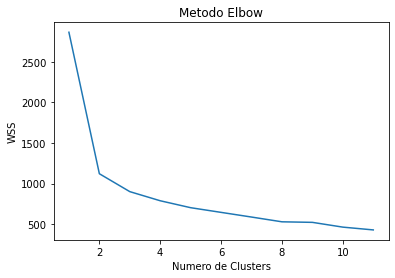

In [20]:
# Treinando o modelo com vários valores de k para verificar qual é o melhor do ponto de vista da inertia
wcss = []
 
for i in range(1, 12):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(df_novo_normal)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 12), wcss)
plt.title('Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

A partir de k = 3, pode-se verificar que não há uma diminuição tão expressiva da inertia (somatório dos erros quadráticos)

In [21]:
# Treinando o modelo com o valor de k = 3
modelo = KMeans(n_clusters = 3).fit(df_novo_normal)

In [22]:
# Treinando o modelo com vários valores de k para verificar qual é o melhor do ponto de vista da variância explicada
# Determinando um range de K
k_range = range(1,12)

In [23]:
# Aplicando o modelo K-Means para cada valor de K
k_means_var = [KMeans(n_clusters = k).fit(df_novo_normal) for k in k_range]

In [24]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [25]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(df_novo_normal, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

In [26]:
# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [27]:
# Soma total dos quadrados
soma_total = sum(pdist(df_novo_normal)**2)/df_novo_normal.shape[0]

In [28]:
# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Valor de K')

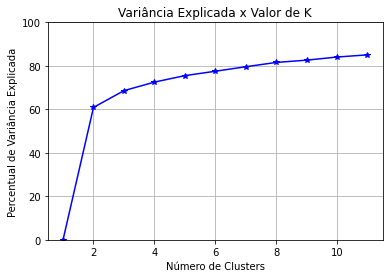

In [29]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

In [30]:
# Como no gráfico acima, o valor de k=8 parece explicar melhor a variância, um novo modelo será criado com k=8.
# Treinando o modelo com o valor de k = 8
modelo2 = KMeans(n_clusters = 8).fit(df_novo_normal)

In [31]:
# Silhouette Score: O melhor valor é 1 e o pior é -1. Valores próximos a 0 indicam sobreposição de cluster

# Verificando o Silhouette Score para o modelo 1
labels = modelo.labels_
silhouette_score(df_novo_normal, labels, metric = 'euclidean')

0.6134337866524986

In [32]:
# Verificando o Silhouette Score para o modelo 2
labels = modelo2.labels_
silhouette_score(df_novo_normal, labels, metric = 'euclidean')

0.3011815262543608

O k que apresentou a melhor pontuação foi o k=3, logo, este será utilizado para divisão dos clusters.

### Análise numérica dos clusters

In [33]:
# Verificando os labels do modelo
modelo.labels_

array([1, 0, 1, ..., 0, 0, 0])

In [34]:
# Incluindo os labels no dataset anterior
df_pronto["cluster"] = modelo.labels_
df_pronto.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
1541853,1.264,0.000,238.15,5.2,0.0,0.0,18.0,1
820069,0.138,0.000,237.89,0.6,0.0,0.0,0.0,0
490805,1.320,0.000,240.37,5.4,0.0,0.0,18.0,1
1416358,1.618,0.340,239.24,6.8,0.0,2.0,18.0,1
226398,2.136,0.246,236.26,9.4,0.0,27.0,0.0,0


In [35]:
# Verificando a quantidade de cluster
df_pronto.cluster.unique()

array([1, 0, 2], dtype=int64)

In [36]:
# Calculando a média de consumo de energia por cluster (usando a coluna Global_active_power para o cálculo da média)
df_pronto.groupby(["cluster"])["Global_active_power"].mean()

cluster
0    0.531808
1    1.749276
2    4.122505
Name: Global_active_power, dtype: float64

### Fim